# **1. Import necessary libraries**

In [ ]:
import os
import tweepy as tw
import pandas as pd
import csv
import pandas as pd
import glob
from nltk.corpus import stopwords
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
import keras.models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import backend as K
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import namedtuple
import seaborn as sns
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **2. Necessary Data Cleaning Functions**

**Function to concatenate all csv files into one large corpus**

In [ ]:
def create_data_corpus(path):
  files = glob.glob(path + "/*.csv")
  df_list = []
  
  for file in files:
    df = pd.read_csv(file, index_col=None, header=0, engine='python')
    df_list.append(df)

  frame = pd.concat(df_list, axis=0, ignore_index=True)
  return frame

**Function to remove certain patterns in the data**

In [ ]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

**Function to carry out data cleaning**

In [ ]:
def clean_tweets(frame, column_name, remove_stop_words=True, lower_case=True, remove_special=True):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs

  if remove_special:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words
  if lower_case:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: x.lower())
  if remove_stop_words:
    frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')])) #remove stop words

  return frame

# **3. Preprocess the Dataset(Combined corpus of SemEval2017 + Airlines + subset of Sentiment140) for training the Networks**

In [ ]:
mega_frame = create_data_corpus('drive/My Drive/SentimentAnalysis/MegaData') #Use this path only (Modify if needed)
mega_frame = clean_tweets(frame=mega_frame, column_name='Column3', remove_stop_words=False, remove_special=False)
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...
...,...,...,...,...
114213,2.192225e+09,positive,Hahaha! @futureguru100 that was just a work p...,hahaha! that was just a work project... he cou...
114214,2.191751e+09,positive,And the award for 'Longest Ever Interview' goe...,and the award for 'longest ever interview' goe...
114215,1.468895e+09,negative,Thinks!!!!!! i should have rented wheelman,thinks!!!!!! i should have rented wheelman
114216,1.469237e+09,negative,@MaryBethune I hate school right now! You are ...,i hate school right now! you are lucky you do...


In [ ]:
mega_frame['Column2'].value_counts()

positive    47028
negative    41842
neutral     25348
Name: Column2, dtype: int64

# **4. Build the Inputs to our networks**

**One-hot encode the labels**

In [ ]:
mega_frame["Sentiment_Value"] = mega_frame["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
labels = to_categorical(mega_frame["Sentiment_Value"], 3)
mega_frame

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,4.343150e+17,negative,@MetroNorth wall to wall people on the platfor...,wall to wall people on the platform at south ...,2
1,4.376050e+17,neutral,ang sarap mging panganay. Pag ikaw may kylngan...,ang sarap mging panganay. pag ikaw may kylngan...,0
2,4.374240e+17,negative,RT @katie_rohaley: School on Monday is just go...,school on monday is just gonna be a great time,2
3,4.368360e+17,negative,Thanks manager for putting me on the schedule ...,thanks manager for putting me on the schedule ...,2
4,4.356710e+17,negative,Who needs sleep? It's not like I have a test t...,who needs sleep? it's not like i have a test t...,2
...,...,...,...,...,...
114213,2.192225e+09,positive,Hahaha! @futureguru100 that was just a work p...,hahaha! that was just a work project... he cou...,1
114214,2.191751e+09,positive,And the award for 'Longest Ever Interview' goe...,and the award for 'longest ever interview' goe...,1
114215,1.468895e+09,negative,Thinks!!!!!! i should have rented wheelman,thinks!!!!!! i should have rented wheelman,2
114216,1.469237e+09,negative,@MaryBethune I hate school right now! You are ...,i hate school right now! you are lucky you do...,2


**Get statistics of our data**

In [ ]:
mega_frame['test'] = mega_frame['Tweet_Clean_Text'].apply(lambda x: len(str(x).split()))
print("mean length of sentence: " + str(mega_frame.test.mean()))
print("max length of sentence: " + str(mega_frame.test.max()))
print("std dev length of sentence: " + str(mega_frame.test.std()))

mean length of sentence: 15.85478646097813
max length of sentence: 39
std dev length of sentence: 6.794046007912811


**Vectorize and convert text into sequences**

In [ ]:
maxlen = mega_frame.test.max()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(mega_frame['Tweet_Clean_Text'].values)
num_features = len(tokenizer.word_index) + 1
X = tokenizer.texts_to_sequences(mega_frame['Tweet_Clean_Text'].values)
X = pad_sequences(X, maxlen=maxlen, padding='post')

print("Vocab size: ", num_features)
print("Input shape: ", X.shape)
print("Labels shape: " , labels.shape)

Vocab size:  73456
Input shape:  (114218, 39)
Labels shape:  (114218, 3)


**Save the Tokenizer state for later use**

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Function to get GloVe embeddings**

In [ ]:
def get_w2v(path):
  file = open(path)
  w2v = {}
  for embedding_line in file:
    embedding_word = embedding_line.split()[0]
    embedding_value = np.asarray([float(value) for value in embedding_line.split()[1:]])
    w2v[embedding_word] = embedding_value
  return w2v

In [ ]:
glove_file_path = "drive/My Drive/SentimentAnalysis/GloVe/glove.twitter.27B.200d.txt"
w2v = get_w2v(glove_file_path)

In [ ]:
embedding_dim = 200
emb_mat = np.zeros((num_features, embedding_dim))
for word, i in tokenizer.word_index.items():
  vector = w2v.get(word)
  if vector is not None:
    emb_mat[i] = vector
  else:
    emb_mat[i] = np.random.randn(200)

**Create Training, Validation, and Test Data splits**

In [ ]:
#FINAL DATASETS (Please note case sensitivity)- TRAINING: (X_train,Y_train)  VALIDATION: (X_val, Y_val)  TEST: (X_test, Y_test)

Y = labels

x_train, X_test, y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 1)

X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=1)

# **5. Build LSTM and CNN models**

## **Model helpers (metrics, callbacks, plots)**

### **Metrics**

In [ ]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1_metrics'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
]

### **Training Plots**

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 15, 10

def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

**Correlation Matrix**

In [ ]:
def correlation_matrix(models):
  train_predictions = []

  for model in models:
    train_predictions.append(model.predict([X_train], batch_size=1024))

  ndarray = np.array(train_predictions)
  positive = ndarray[:,:,0]
  neutral = ndarray[:,:,1]
  negative = ndarray[:,:,2]

  average = (np.corrcoef(positive) + np.corrcoef(neutral) + np.corrcoef(negative))/3

  sns.set_theme(style="white")

  mask = np.triu(np.ones_like(average, dtype=bool))

  f, ax = plt.subplots(figsize=(11,9))

  cmap = sns.diverging_palette(220,20, n=9, as_cmap=True)

  sns.heatmap(average, mask=mask, cmap=cmap, vmax=1, vmin=.75, center=.9,
              square=True, linewidth=.5, cbar_kws={"shrink":.5})

### **Callbacks**

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=1, verbose=1)

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch > 9:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.h5".format(epoch))

saver = CustomSaver()

## **LSTM Models**

**LSTM Model 1**

In [ ]:
def Build_LSTM_Model1():
  output_dims = 200
  lstm_out = 200
  dropout = 0.4
  recurrent_dropout = 0.4
  spatial_dropout_rate = 0.4
 
  model1 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.SpatialDropout1D(rate=spatial_dropout_rate),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
  
  return model1, model_info

**LSTM Model 2**

In [ ]:
def Build_LSTM_Model2():
  output_dims = 200
  lstm_out = 50
  dropout=0.6
  recurrent_dropout=0.6
  spatial_dropout_rate = 0.6
 
  model2 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.SpatialDropout1D(rate=spatial_dropout_rate),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dense(units=50, activation='relu'),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
 
  return model2, model_info

**LSTM Model 3**

In [ ]:
def Build_LSTM_Model3():
  output_dims = 200
  lstm_out = 100
  dropout=0.2
  recurrent_dropout=0.2
 
  model3 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dropout(rate=dropout),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
 
  return model3, model_info

**LSTM Model 4**

In [ ]:
def Build_LSTM_Model4():
  output_dims = 200
  lstm_out = 150
  dropout=0.3
  recurrent_dropout=0.3
 
  model4 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
  
  return model4, model_info

**LSTM Model 5**

In [ ]:
def Build_LSTM_Model5():
  output_dims = 200
  lstm_out = 250
  dropout=0.5
  recurrent_dropout=0.5
 
  model5 = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1], weights=[emb_mat], trainable=True),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=False)),
      layers.Dense(units=3, activation='softmax')
      ])
  
  model_info = (lstm_out, 'LSTM')
  
  return model5, model_info

## **CNN Models**

**Flat CNN Model 1**

In [ ]:
def Build_FlatCNN_Model1():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [2,3,4]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info


**FLAT CNN Model 2**

In [ ]:
def Build_FlatCNN_Model2():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [3,4,5]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info

**FLAT CNN Model 3**

In [ ]:
def Build_FlatCNN_Model3():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [5,6,7]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info

**FLAT CNN Model 4**

In [ ]:
def Build_FlatCNN_Model4():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [7,8,9]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info

**FLAT CNN Model 5**

In [ ]:
def Build_FlatCNN_Model5():
  INPUT_DIMS = (200, maxlen, 1)
  REGION_SIZES = [9,10,11]
  FILTERS_PER_REGION = 8
  output_dims = 200
  dropout=0.25

  inputs = keras.Input(shape=(maxlen,), dtype='int32')
  embedding_layer = layers.Embedding(input_dim=num_features, output_dim=output_dims, weights = [emb_mat], trainable=True)(inputs)
  parallel_layers = []
  for size in REGION_SIZES:
    parallel_layer = keras.layers.Reshape((INPUT_DIMS[0],INPUT_DIMS[1], INPUT_DIMS[2]))(embedding_layer)
    parallel_layer = keras.layers.Conv2D(FILTERS_PER_REGION, (INPUT_DIMS[0], size), activation='relu')(parallel_layer)
    parallel_layer = keras.layers.MaxPool2D(pool_size=(1,size))(parallel_layer)
    parallel_layers.append(parallel_layer)
  merged = keras.layers.concatenate(parallel_layers, axis=2)
  flatten = keras.layers.Flatten()(merged)
  hidden = keras.layers.Dense(FILTERS_PER_REGION * len(REGION_SIZES), activation='relu')(flatten)
  hidden = keras.layers.Dropout(rate=dropout)(hidden)
  output = keras.layers.Dense(3, activation= 'softmax')(hidden)
  model = keras.Model(inputs, output)

  model_info = (REGION_SIZES, 'FLATCNN')
  return model, model_info

# **Train Models**

**Change directory to save models**

In [ ]:
os.chdir("/content/drive/MyDrive/SentimentAnalysis/Models")

**Model Generator**

In [ ]:
def model_gen(model_functions, metrics, callbacks):
  models =[]
  histories = []

  for model_fn in model_functions:
    model, model_info = model_fn()

    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=model_info[1] + str(model_info[0]) + '.h5',
        save_weights_only=False,
        monitor='val_f1_metrics',
        mode='max',
        save_best_only=True,
        save_freq='epoch'
        )
    
    if len(callbacks)>2:
      del callbacks[-1]
      
    callbacks.append(model_checkpoint)

    model.compile(optimizer='adam',
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=metrics
                  )

    history = model.fit(X_train,
                        Y_train,
                        batch_size=3000,
                        epochs=20,
                        validation_data=(X_val,Y_val),
                        shuffle=True,
                        callbacks=callbacks
                        )
    
    models.append(model)
    histories.append(history)

  return models, histories

**Training LSTM**

In [ ]:
model_functions = [Build_LSTM_Model1, Build_LSTM_Model2, Build_LSTM_Model3, Build_LSTM_Model4, Build_LSTM_Model5]
callbacks = [early_stopping_callback, reduce_lr_callback]
lstm_models, lstm_histories = model_gen(model_functions=model_functions,metrics=metrics, callbacks=callbacks)

Epoch 1/20
31/31 [==============================] - 43s 1s/step - loss: 0.9898 - categorical_accuracy: 0.5585 - precision: 0.6876 - recall: 0.3305 - f1_metrics: 0.2439 - val_loss: 0.7968 - val_categorical_accuracy: 0.6359 - val_precision: 0.6694 - val_recall: 0.5760 - val_f1_metrics: 0.6193
Epoch 2/20
31/31 [==============================] - 37s 1s/step - loss: 0.8088 - categorical_accuracy: 0.6242 - precision: 0.6704 - recall: 0.5329 - f1_metrics: 0.5938 - val_loss: 0.7224 - val_categorical_accuracy: 0.6697 - val_precision: 0.7039 - val_recall: 0.6244 - val_f1_metrics: 0.6634
Epoch 3/20
31/31 [==============================] - 36s 1s/step - loss: 0.7668 - categorical_accuracy: 0.6504 - precision: 0.6953 - recall: 0.5702 - f1_metrics: 0.6266 - val_loss: 0.7047 - val_categorical_accuracy: 0.6772 - val_precision: 0.7079 - val_recall: 0.6398 - val_f1_metrics: 0.6733
Epoch 4/20
31/31 [==============================] - 36s 1s/step - loss: 0.7330 - categorical_accuracy: 0.6687 - precision: 0

In [ ]:
best_indiv = 0.0
for history in lstm_histories:
  best_indiv = max(best_indiv, max(history.history['val_f1_metrics']))
print("Best individual F1 = {}".format(best_indiv))

Best individual F1 = 0.7258492708206177


In [ ]:
for i, lstm_model in enumerate(lstm_models):
  print("\nLSTM_Model_{0}".format(i+1))
  lstm_model.evaluate(X_test, Y_test, batch_size=1000)


LSTM_Model_1
12/12 [==============================] - 1s 108ms/step - loss: 0.6577 - categorical_accuracy: 0.7148 - precision: 0.7318 - recall: 0.6895 - f1_metrics: 0.7108

LSTM_Model_2
12/12 [==============================] - 1s 56ms/step - loss: 0.7881 - categorical_accuracy: 0.6597 - precision: 0.6752 - recall: 0.6340 - f1_metrics: 0.6542

LSTM_Model_3
12/12 [==============================] - 1s 69ms/step - loss: 0.6918 - categorical_accuracy: 0.7127 - precision: 0.7255 - recall: 0.6951 - f1_metrics: 0.7098

LSTM_Model_4
12/12 [==============================] - 1s 83ms/step - loss: 0.6890 - categorical_accuracy: 0.7151 - precision: 0.7268 - recall: 0.6984 - f1_metrics: 0.7126

LSTM_Model_5
12/12 [==============================] - 1s 111ms/step - loss: 0.6625 - categorical_accuracy: 0.7189 - precision: 0.7305 - recall: 0.6988 - f1_metrics: 0.7139


**LSTM Models Training Plots**

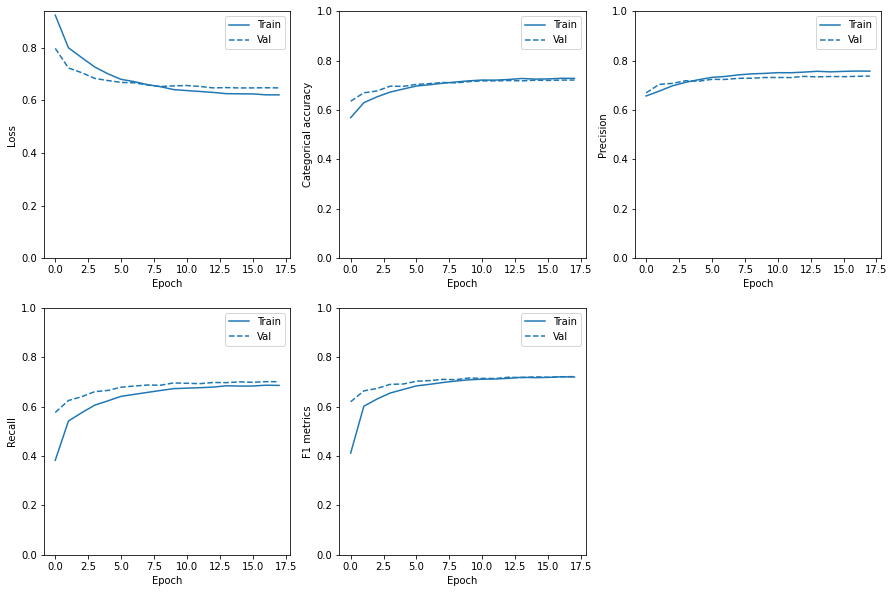

In [ ]:
plot_metrics(lstm_histories[0])

**Correlation Matrix for LSTM**

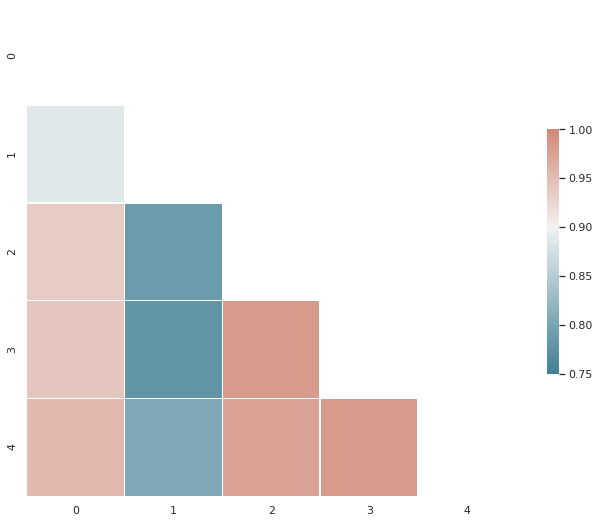

In [ ]:
correlation_matrix(lstm_models)

**Training CNN**

In [ ]:
model_functions = [Build_FlatCNN_Model1, Build_FlatCNN_Model2, Build_FlatCNN_Model3, Build_FlatCNN_Model4, Build_FlatCNN_Model5]
callbacks = [early_stopping_callback, reduce_lr_callback]
flat_cnn_models, flat_cnn_histories = model_gen(model_functions=model_functions,metrics=metrics, callbacks=callbacks)

Epoch 1/20
31/31 [==============================] - 37s 300ms/step - loss: 1.0638 - categorical_accuracy: 0.4958 - precision: 0.7130 - recall: 0.1861 - f1_metrics: 0.0192 - val_loss: 0.9827 - val_categorical_accuracy: 0.5232 - val_precision: 0.7024 - val_recall: 0.0873 - val_f1_metrics: 0.1528
Epoch 2/20
31/31 [==============================] - 8s 264ms/step - loss: 0.9557 - categorical_accuracy: 0.5235 - precision: 0.6384 - recall: 0.2153 - f1_metrics: 0.3173 - val_loss: 0.8812 - val_categorical_accuracy: 0.5926 - val_precision: 0.6869 - val_recall: 0.3847 - val_f1_metrics: 0.4920
Epoch 3/20
31/31 [==============================] - 8s 273ms/step - loss: 0.8501 - categorical_accuracy: 0.6017 - precision: 0.6754 - recall: 0.4381 - f1_metrics: 0.5308 - val_loss: 0.8118 - val_categorical_accuracy: 0.6292 - val_precision: 0.6856 - val_recall: 0.5098 - val_f1_metrics: 0.5852
Epoch 4/20
31/31 [==============================] - 8s 264ms/step - loss: 0.7736 - categorical_accuracy: 0.6520 - pre

**Get best individual F1**

In [ ]:
best_indiv = 0.0
for history in flat_cnn_histories:
  best_indiv = max(best_indiv, max(history.history['val_f1_metrics']))
print("Best individual F1 = {}".format(best_indiv))

Best individual F1 = 0.6718630790710449


**Evalute FLAT CNN on Test Data**

In [ ]:
for i, flat_cnn_model in enumerate(flat_cnn_models):
  print("\nFlat_CNN_Model_{0}".format(i+1))
  flat_cnn_model.evaluate(X_test, Y_test, batch_size=1000)


Flat_CNN_Model_1
12/12 [==============================] - 1s 52ms/step - loss: 0.7979 - categorical_accuracy: 0.6642 - precision: 0.6852 - recall: 0.6290 - f1_metrics: 0.6567

Flat_CNN_Model_2
12/12 [==============================] - 0s 29ms/step - loss: 0.7817 - categorical_accuracy: 0.6599 - precision: 0.6836 - recall: 0.6230 - f1_metrics: 0.6530

Flat_CNN_Model_3
12/12 [==============================] - 1s 44ms/step - loss: 0.7792 - categorical_accuracy: 0.6670 - precision: 0.6864 - recall: 0.6370 - f1_metrics: 0.6605

Flat_CNN_Model_4
12/12 [==============================] - 1s 44ms/step - loss: 0.7882 - categorical_accuracy: 0.6722 - precision: 0.6944 - recall: 0.6381 - f1_metrics: 0.6650

Flat_CNN_Model_5
12/12 [==============================] - 1s 46ms/step - loss: 0.7762 - categorical_accuracy: 0.6740 - precision: 0.6928 - recall: 0.6438 - f1_metrics: 0.6682


**FLAT CNN Models Training Plots**

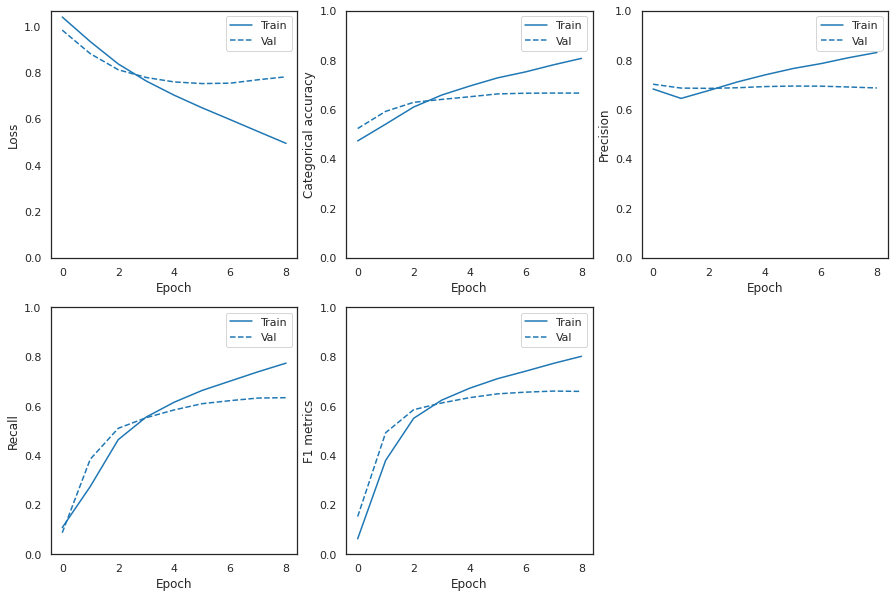

In [ ]:
plot_metrics(flat_cnn_histories[0])

**Correlation Matrix for Flat CNN**

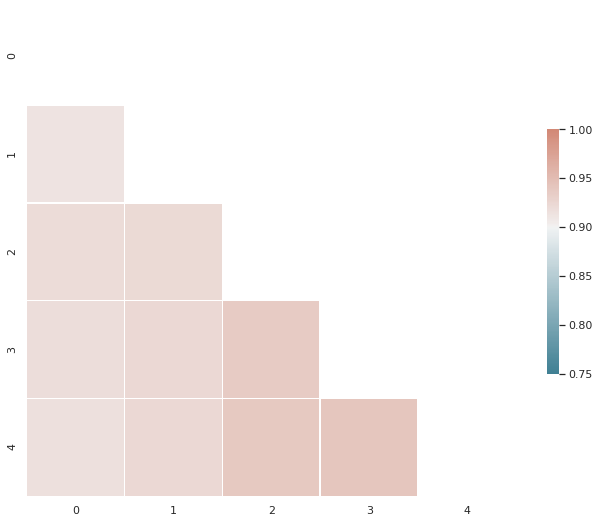

In [ ]:
correlation_matrix(flat_cnn_models)